In [2]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from verificators_new import ActiveVerificator, AgglomerativeVerificator, \
    MeanShiftVerificator, AffinityVerificator, DBSCANVerificator, \
    SpectralVerificator, AgglomerativeUpdateVerificator
from tester_new import ClusteringTester

In [5]:
with open('data/vox1_embeddings_labeled.pkl', 'rb') as f:
	embeddings, labels = tuple(map(np.array, pickle.load(f)))

In [6]:
confs = [
    dict(n_users_type1=5, n_utts_per_user_type1=3),
    dict(n_users_type1=5, n_utts_per_user_type1=5),
    dict(n_users_type1=5, n_utts_per_user_type1=10),
    dict(n_users_type1=5, n_utts_per_user_type1=20),
    dict(n_users_type1=5, n_utts_per_user_type1=30),
    dict(n_users_type1=3, n_utts_per_user_type1=30, n_users_type2=5, n_utts_per_user_type2=3),
    dict(n_users_type1=3, n_utts_per_user_type1=30, n_users_type2=5, n_utts_per_user_type2=5),
]

In [17]:
def test_all_confs(verificators=[(lambda th: DBSCANVerificator(th, 5), 5, 1000, np.arange(0.2, 0.99, 0.02), 'DBSCAN-5')], confs=confs):
    n = len(verificators)
    plt.figure(figsize=(5 * n, 25))
    for v, (verificator, min_size, x, n_tests, name) in enumerate(verificators):
        v_measures = np.zeros_like(x, dtype=float)
        found_rates = np.zeros_like(x, dtype=float)
        for conf in tqdm(confs):
            if conf['n_utts_per_user_type1'] < min_size:
                continue
            tester = ClusteringTester(embeddings, labels, n_tests=n_tests, **conf)
            result = tester.test_all(verificator, x, use_tqdm=False)
            label = '_'.join(map(str, conf.values()))
            plt.subplot(6, n, 1 + v + n * 0)
            plt.title(name)
            plt.plot(x, result.v_measure.values, label=label)
            if v == 0:
                plt.ylabel('Identification V-measure')
            plt.ylim(0.9, 1)
            plt.subplot(6, n, 1 + v + n * 1)
            plt.plot(x, result.homogeinity.values, label=label)
            if v == 0:
                plt.ylabel('Homogeinity')
            plt.ylim(0.9, 1)
            plt.subplot(6, n, 1 + v + n * 2)
            plt.plot(x, result.completeness.values, label=label)
            if v == 0:
                plt.ylabel('Completeness')
            plt.ylim(0.9, 1)
            plt.subplot(6, n, 1 + v + n * 3)
            plt.plot(x, result.guest_detection_eer.values, label=label)
            if v == 0:
                plt.ylabel('Guest EER')
            plt.ylim(0, 0.05)
            plt.subplot(6, n, 1 + v + n * 4)
            plt.plot(x, result.clustering_acc.values, label=label)
            if v == 0:
                plt.ylabel('Clustering accuracy')
            plt.ylim(0, 1)
            plt.subplot(6, n, 1 + v + n * 5)
            plt.plot(x, result.found_rate.values, label=label)
            if v == 0:
                plt.ylabel('Speaker detection rate')
            plt.xlabel('θ_c')
            plt.ylim(0, 1)
            #print(v_measures, result.v_measure.values)
            #print(result.v_measure.values)
            v_measures += np.nan_to_num(result.v_measure.values, nan=1.0)
            found_rates += result.found_rate.values
        opt = np.argmax(v_measures * (x > 0.45))# * (x < 0.75))
        #print(v_measures)
        for i in range(6):
            plt.subplot(6, n, 1 + v + n * i)
            plt.axvline(x=x[opt], linestyle='--', label=f'θ_c = {round(x[opt], 2)}')
            plt.legend()
    plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [35:30<00:00, 304.34s/it]


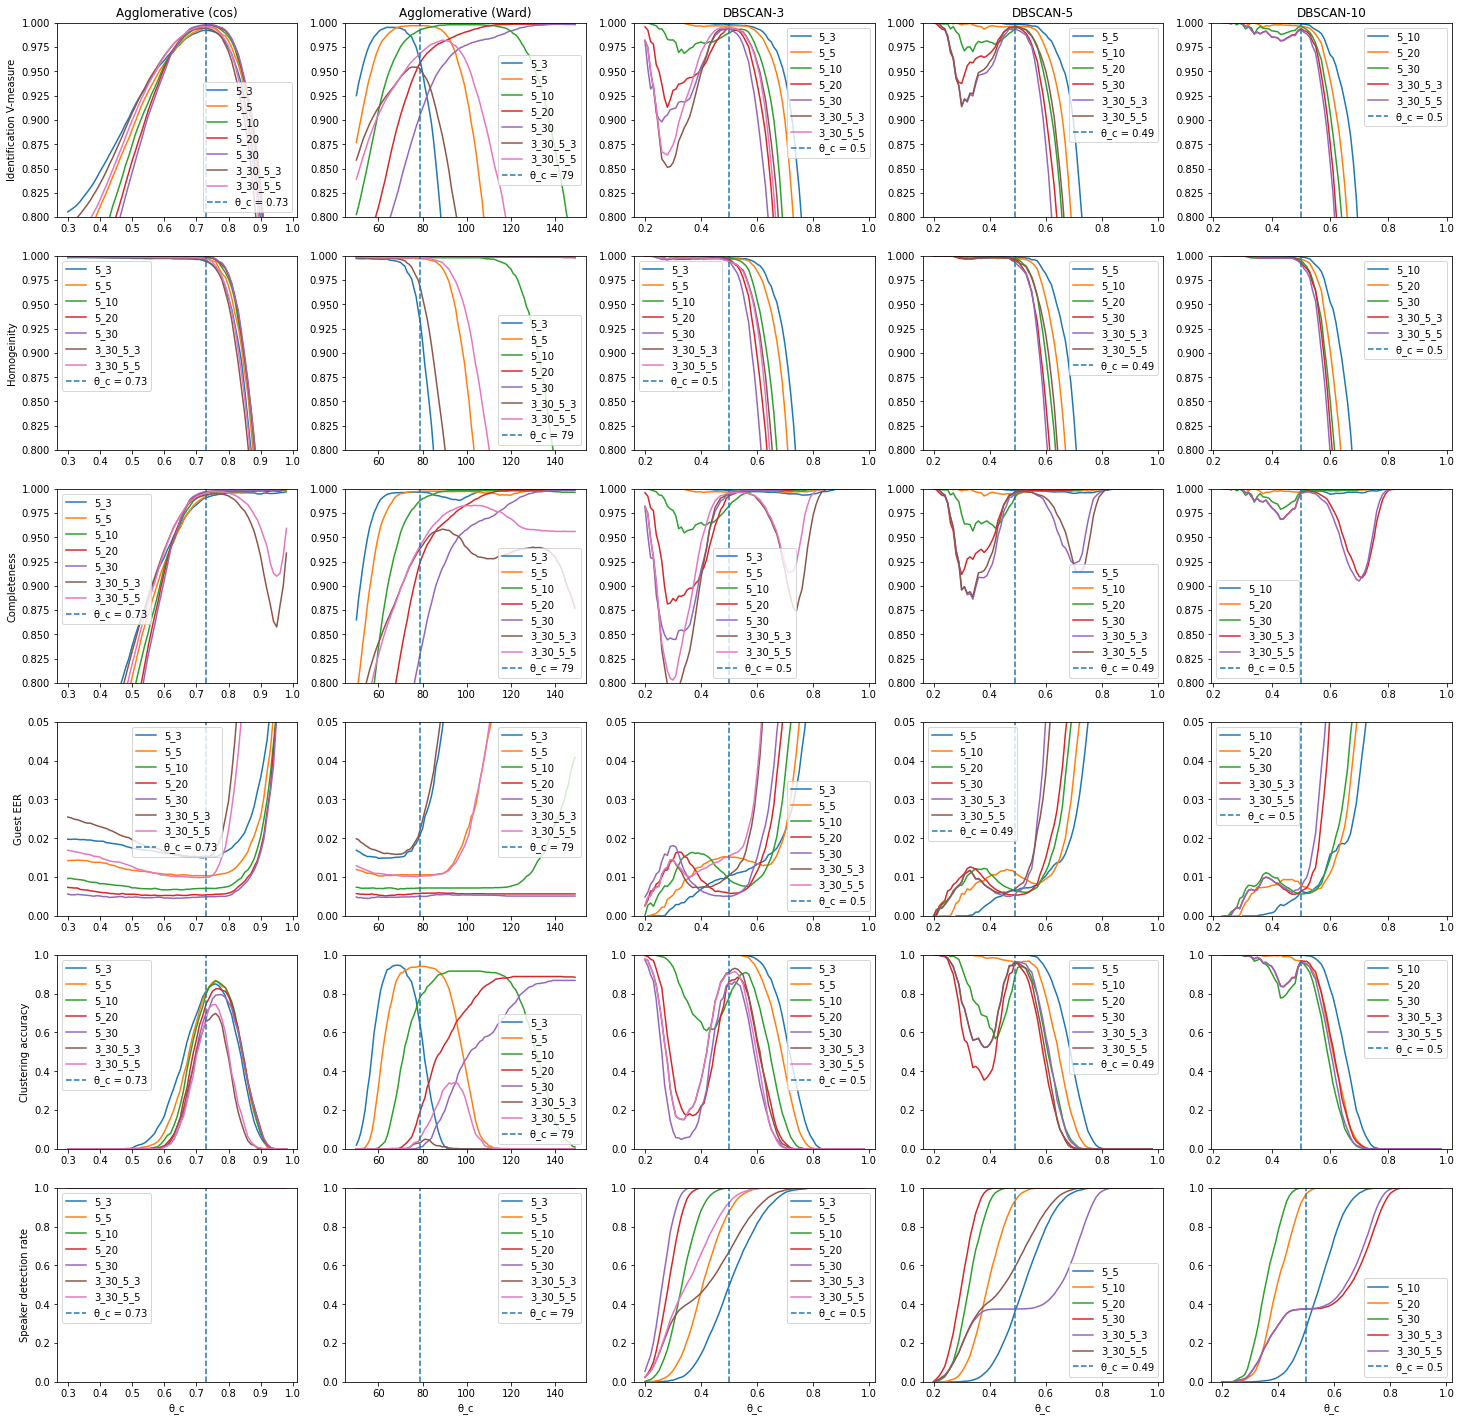

In [29]:
test_all_confs([
    (lambda th: AgglomerativeVerificator(th, 'cosine', 'average'), 1, np.arange(0.3, 0.99, 0.01), 500, 'Agglomerative (cos)'),
    (lambda th: AgglomerativeVerificator(th, 'euclidean', 'ward'), 1, np.arange(50, 150, 1), 500, 'Agglomerative (Ward)'),
    (lambda th: DBSCANVerificator(th, 3), 3, np.arange(0.2, 0.99, 0.01), 1000, 'DBSCAN-3'), 
    (lambda th: DBSCANVerificator(th, 5), 5, np.arange(0.2, 0.99, 0.01), 1000, 'DBSCAN-5'), 
    (lambda th: DBSCANVerificator(th, 10), 10, np.arange(0.2, 0.99, 0.01), 1000, 'DBSCAN-10'),
    #(lambda th: MeanShiftVerificator(th), 1, np.arange(35, 50, 0.5), 50, 'MeanShift')
])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [06:11<00:00, 53.08s/it]


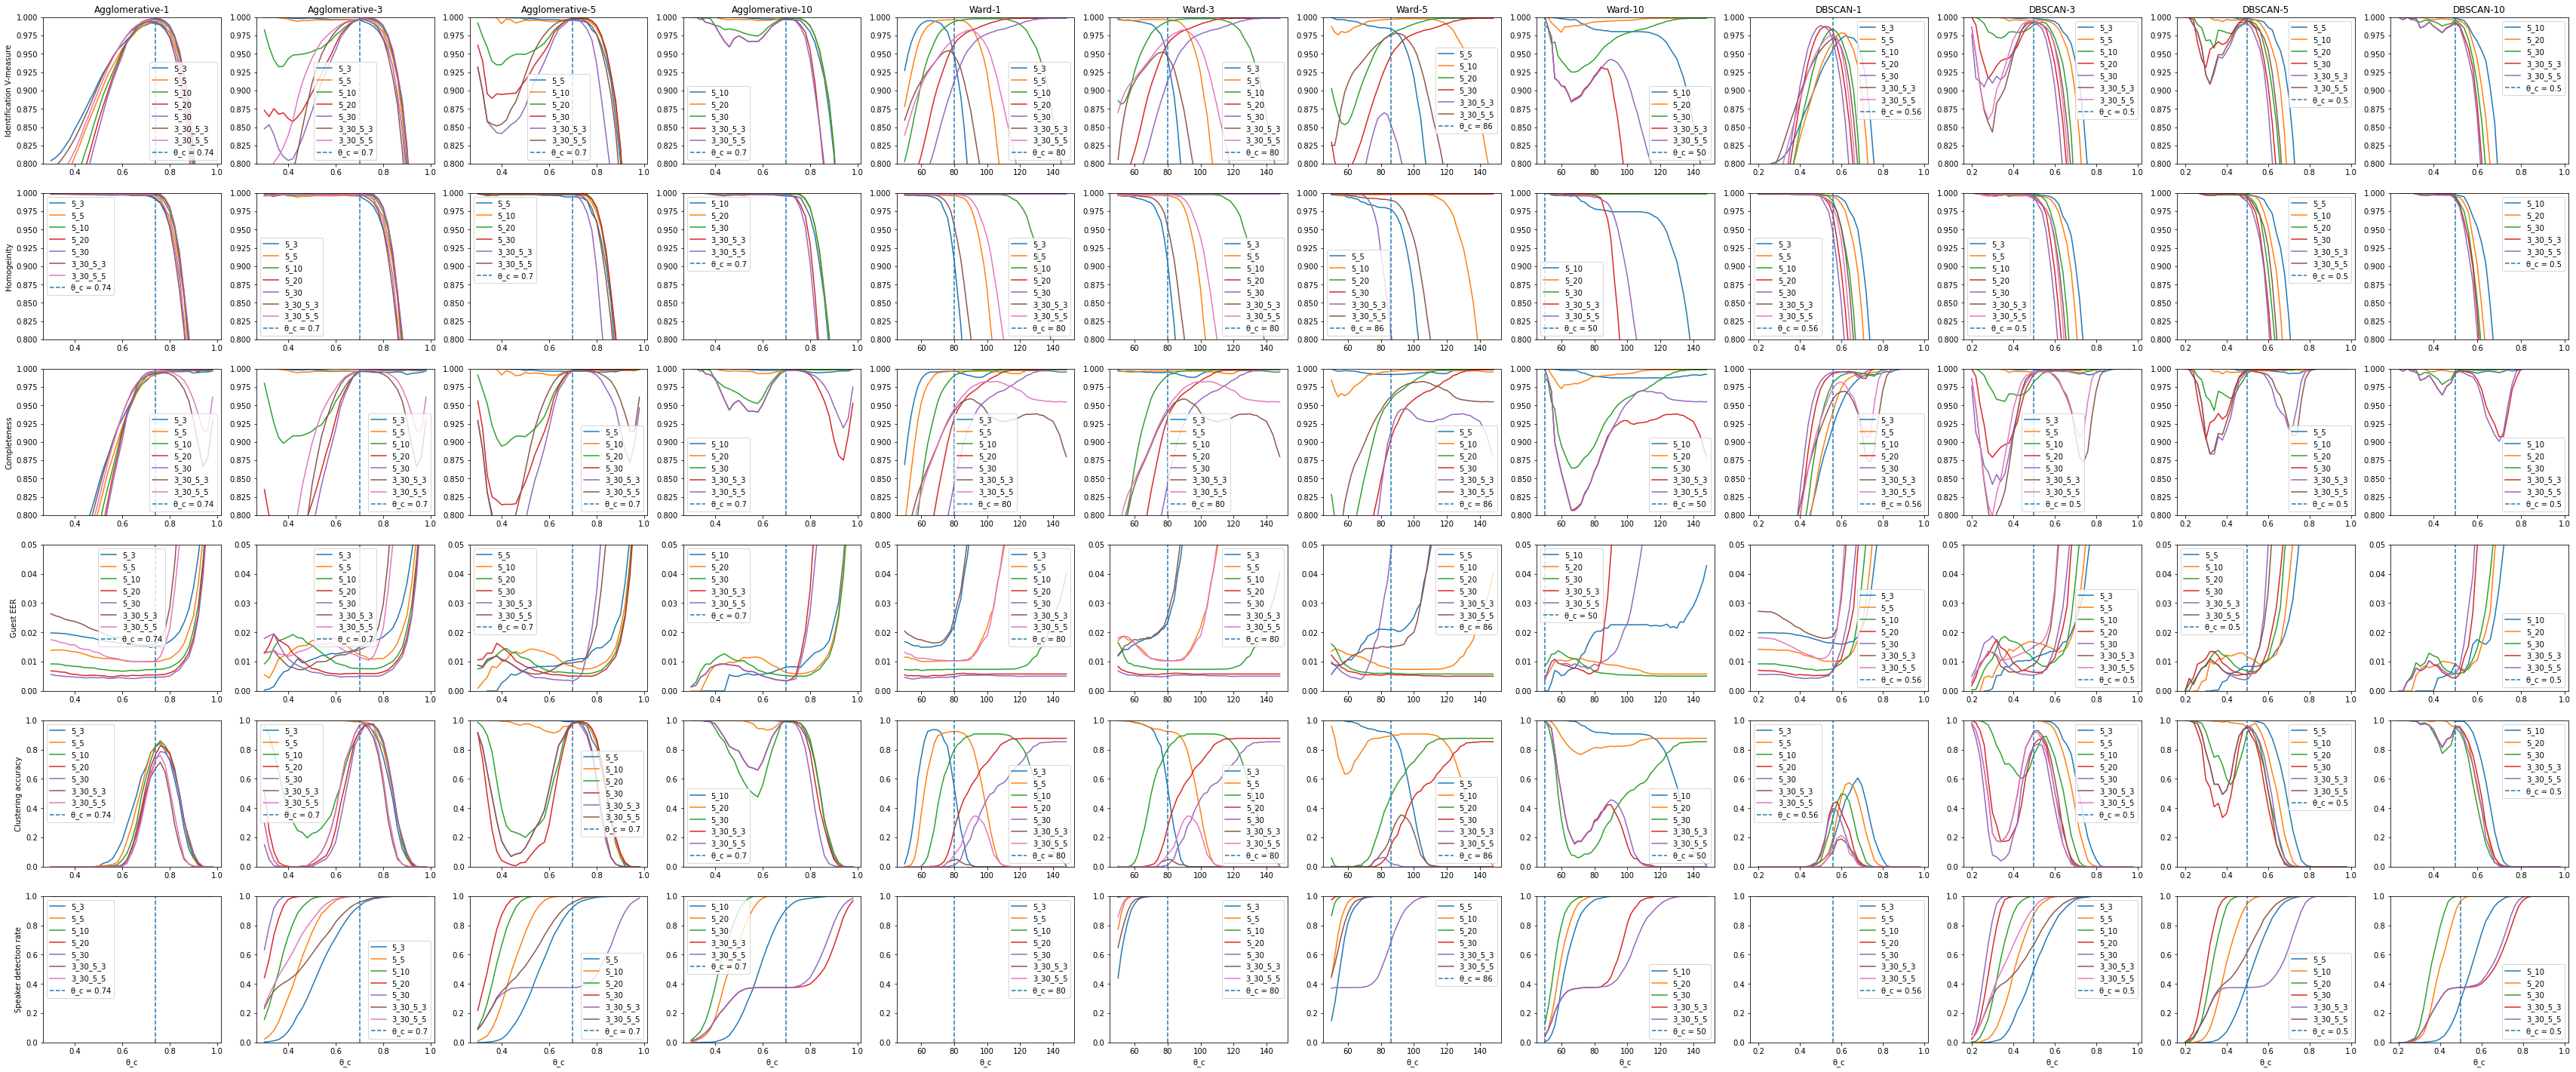

In [58]:
test_all_confs([
    (lambda th: AgglomerativeVerificator(th, 'cosine', 'average', 1), 1, np.arange(0.3, 0.99, 0.02), 300, 'Agglomerative-1'),
    (lambda th: AgglomerativeVerificator(th, 'cosine', 'average', 3), 3, np.arange(0.3, 0.99, 0.02), 300, 'Agglomerative-3'),
    (lambda th: AgglomerativeVerificator(th, 'cosine', 'average', 5), 5, np.arange(0.3, 0.99, 0.02), 300, 'Agglomerative-5'),
    (lambda th: AgglomerativeVerificator(th, 'cosine', 'average', 10), 10, np.arange(0.3, 0.99, 0.02), 300, 'Agglomerative-10'),
    (lambda th: AgglomerativeVerificator(th, 'euclidean', 'ward', 1), 1, np.arange(50, 150, 2), 300, 'Ward-1'),
    (lambda th: AgglomerativeVerificator(th, 'euclidean', 'ward', 3), 3, np.arange(50, 150, 2), 300, 'Ward-3'),
    (lambda th: AgglomerativeVerificator(th, 'euclidean', 'ward', 5), 5, np.arange(50, 150, 2), 300, 'Ward-5'),
    (lambda th: AgglomerativeVerificator(th, 'euclidean', 'ward', 10), 10, np.arange(50, 150, 2), 300, 'Ward-10'),
    (lambda th: DBSCANVerificator(th, 1), 3, np.arange(0.2, 0.99, 0.02), 300, 'DBSCAN-1'), 
    (lambda th: DBSCANVerificator(th, 3), 3, np.arange(0.2, 0.99, 0.02), 300, 'DBSCAN-3'), 
    (lambda th: DBSCANVerificator(th, 5), 5, np.arange(0.2, 0.99, 0.02), 300, 'DBSCAN-5'), 
    (lambda th: DBSCANVerificator(th, 10), 10, np.arange(0.2, 0.99, 0.02), 300, 'DBSCAN-10'),
])

In [24]:
confs = [
    dict(n_users_type1=5, n_utts_per_user_type1=5),
    dict(n_users_type1=10, n_utts_per_user_type1=5),
    dict(n_users_type1=5, n_utts_per_user_type1=10),
    dict(n_users_type1=3, n_utts_per_user_type1=30),
    dict(n_users_type1=3, n_utts_per_user_type1=30, n_users_type2=5, n_utts_per_user_type2=3),
]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:04<00:00, 36.93s/it]


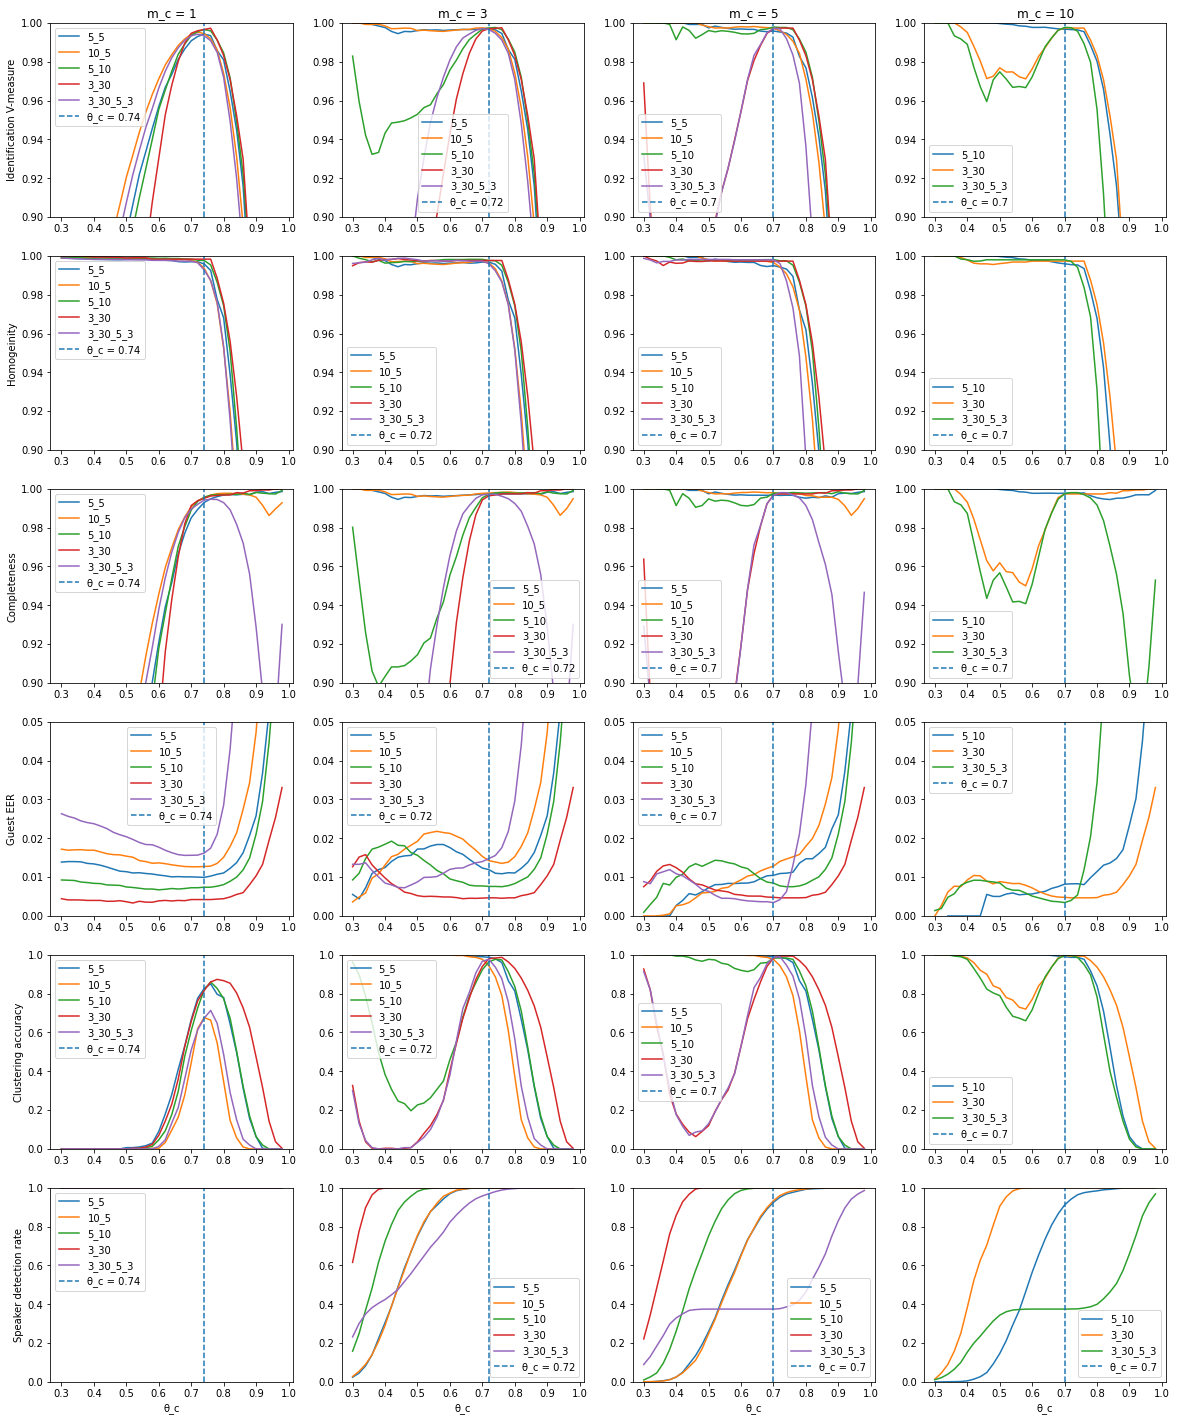

In [14]:
test_all_confs([
    (lambda th: AgglomerativeVerificator(th, 'cosine', 'average', 1), 1, np.arange(0.3, 0.99, 0.02), 300, 'm_c = 1'),
    (lambda th: AgglomerativeVerificator(th, 'cosine', 'average', 3), 3, np.arange(0.3, 0.99, 0.02), 300, 'm_c = 3'),
    (lambda th: AgglomerativeVerificator(th, 'cosine', 'average', 5), 5, np.arange(0.3, 0.99, 0.02), 300, 'm_c = 5'),
    (lambda th: AgglomerativeVerificator(th, 'cosine', 'average', 10), 10, np.arange(0.3, 0.99, 0.02), 300, 'm_c = 10'),
])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:40<00:00, 68.14s/it]


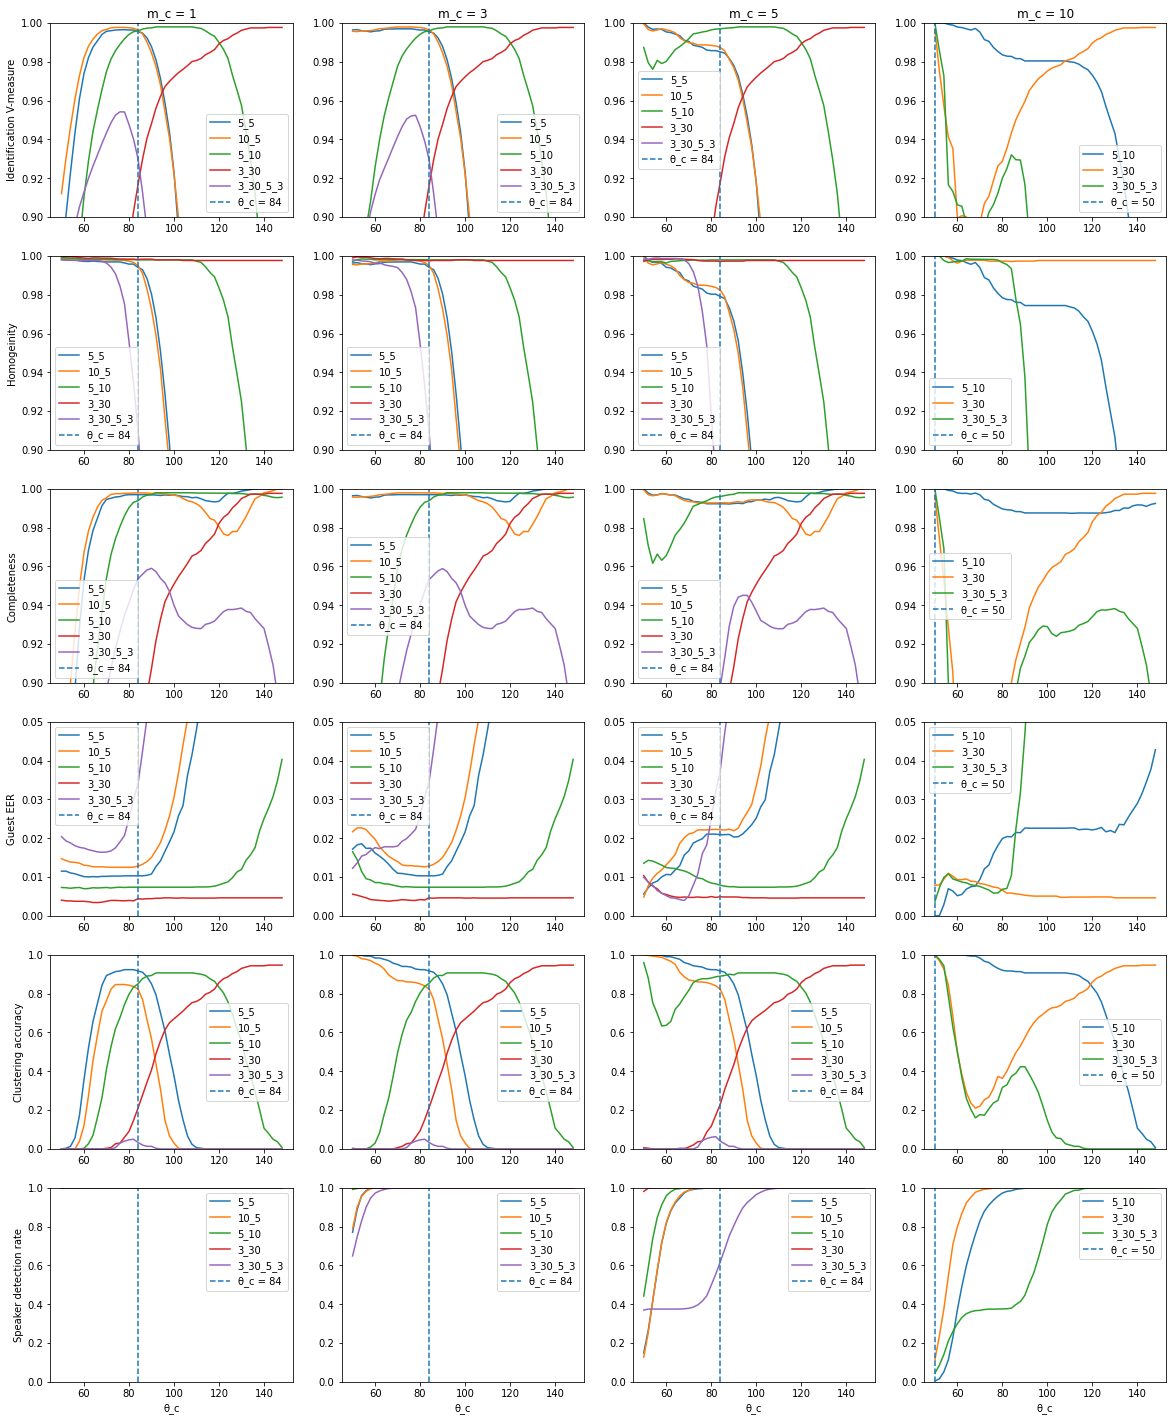

In [18]:
test_all_confs([
    (lambda th: AgglomerativeVerificator(th, 'euclidean', 'ward', 1), 1, np.arange(50, 150, 2), 300, 'm_c = 1'),
    (lambda th: AgglomerativeVerificator(th, 'euclidean', 'ward', 3), 3, np.arange(50, 150, 2), 300, 'm_c = 3'),
    (lambda th: AgglomerativeVerificator(th, 'euclidean', 'ward', 5), 5, np.arange(50, 150, 2), 300, 'm_c = 5'),
    (lambda th: AgglomerativeVerificator(th, 'euclidean', 'ward', 10), 10, np.arange(50, 150, 2), 300, 'm_c = 10'),
])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:01<00:00, 36.35s/it]


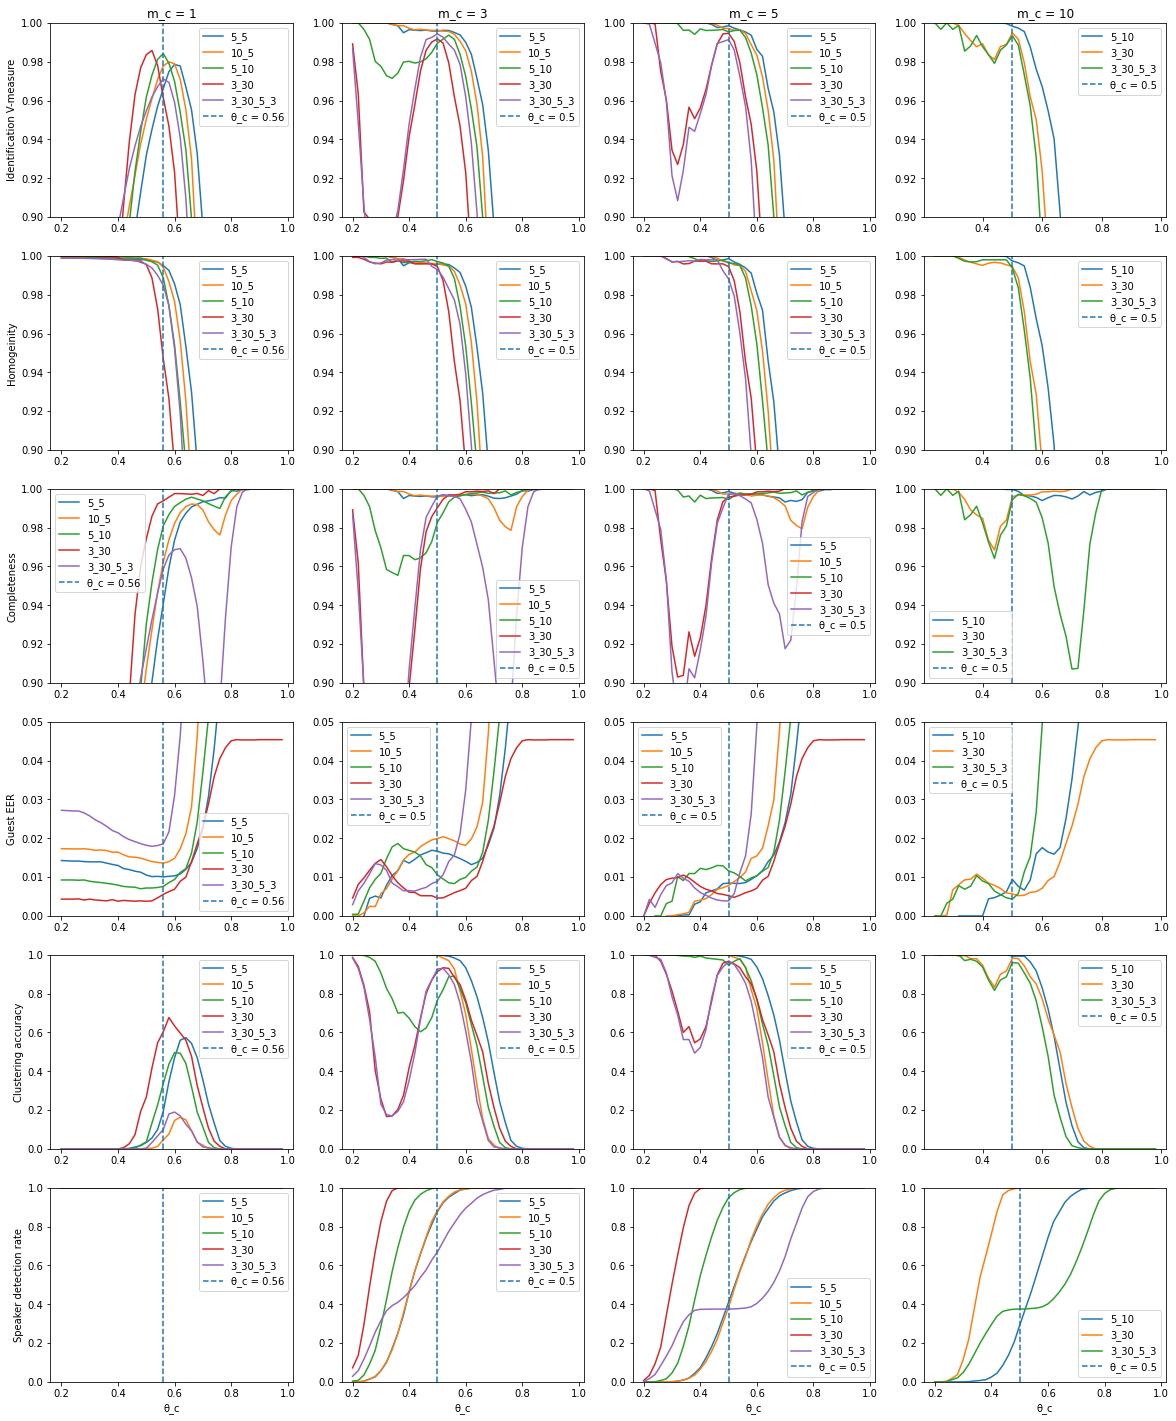

In [16]:
test_all_confs([
    (lambda th: DBSCANVerificator(th, 1), 3, np.arange(0.2, 0.99, 0.02), 300, 'm_c = 1'), 
    (lambda th: DBSCANVerificator(th, 3), 3, np.arange(0.2, 0.99, 0.02), 300, 'm_c = 3'), 
    (lambda th: DBSCANVerificator(th, 5), 5, np.arange(0.2, 0.99, 0.02), 300, 'm_c = 5'), 
    (lambda th: DBSCANVerificator(th, 10), 10, np.arange(0.2, 0.99, 0.02), 300, 'm_c = 10'),
])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [1:14:21<00:00, 892.31s/it]


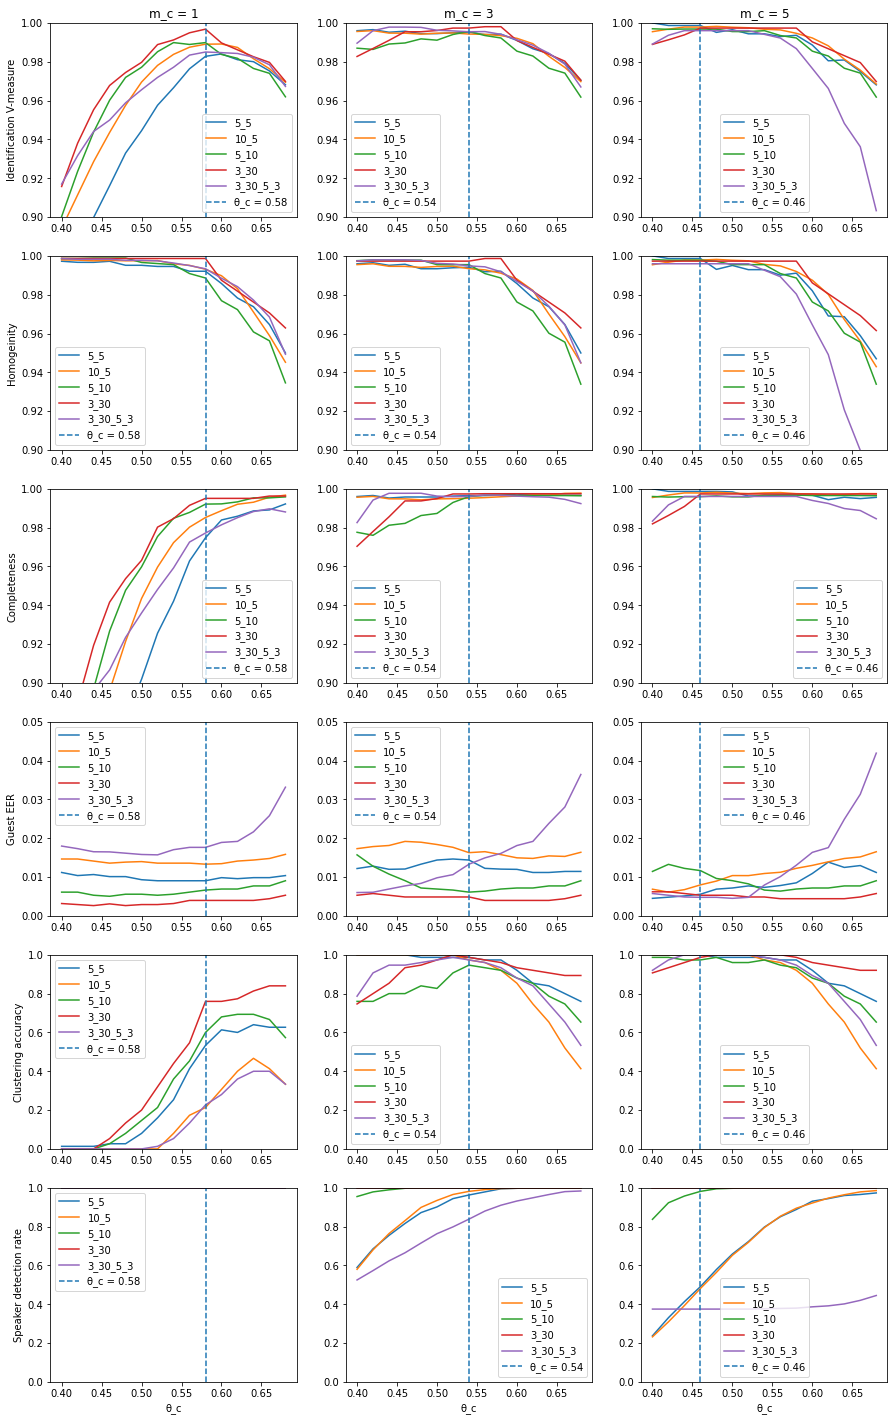

In [22]:
test_all_confs([
    (lambda th: AgglomerativeVerificator(th, 'cosine', 'center', 1), 1, np.arange(0.4, 0.7, 0.02), 75, 'm_c = 1'),
    (lambda th: AgglomerativeVerificator(th, 'cosine', 'center', 3), 3, np.arange(0.4, 0.7, 0.02), 75, 'm_c = 3'),
    (lambda th: AgglomerativeVerificator(th, 'cosine', 'center', 5), 5, np.arange(0.4, 0.7, 0.02), 75, 'm_c = 5'),
    #(lambda th: AgglomerativeVerificator(th, 'cosine', 'center', 10), 10, np.arange(0.3, 0.85, 0.02), 50, 'Center-10'),
])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [1:47:52<00:00, 1294.57s/it]


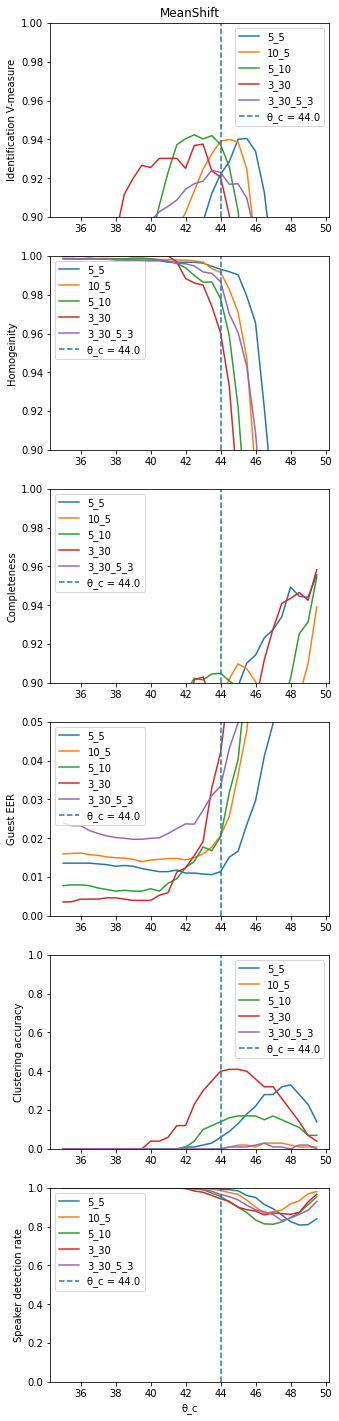

In [21]:
test_all_confs([
    (lambda th: MeanShiftVerificator(th), 1, np.arange(35, 50, 0.5), 100, 'MeanShift'),
])

In [63]:
def table_active(conf):
    tester = ClusteringTester(embeddings, labels, n_tests=10000, **conf)
    results = []
    results.append(dict(name='active', **tester.test(ActiveVerificator())))
    return pd.DataFrame(results)

def table_passive(conf):
    tester = ClusteringTester(embeddings, labels, n_tests=10000, **conf)
    results = []
    #results.append(dict(name='active', **tester.test(ActiveVerificator())))
    results.append(dict(name='agg-cos', **tester.test(AgglomerativeVerificator(0.7, 'cosine', 'average', 5))))
    results.append(dict(name='agg-center', **tester.test(AgglomerativeVerificator(0.46, 'cosine', 'center', 5))))
    results.append(dict(name='agg-ward', **tester.test(AgglomerativeVerificator(84, 'euclidean', 'ward', 1))))
    results.append(dict(name='dbscan', **tester.test(DBSCANVerificator(0.5, 5))))
    #results.append(dict(name='meanshift', **tester.test(MeanShiftVerificator(44))))
    results.append(dict(name='affinity', **tester.test(AffinityVerificator('cosine'))))
    return pd.DataFrame(results)

In [64]:
table_passive(confs[0])

name  v_measure  homogeinity  completeness  guest_detection_eer  \
0     agg-cos   0.997486     0.997118      0.997932             0.009593   
1  agg-center   0.998055     0.998004      0.998122             0.006729   
2    agg-ward   0.996611     0.995599      0.997830             0.009822   
3      dbscan   0.997950     0.997888      0.998235             0.006594   
4    affinity   0.918734     0.896555      0.980761             0.030516   

   clustering_acc  equal_rate  less_rate  more_rate  found_rate  
0          0.9958      0.0000     0.0042     0.0000     0.93112  
1          0.9998      0.0000     0.0002     0.0000     0.48180  
2          0.9465      0.0404     0.0127     0.0004     1.00000  
3          0.9995      0.0000     0.0005     0.0000     0.39432  
4          0.5965      0.0421     0.2950     0.0664     1.00000

In [65]:
table_passive(confs[1])

name  v_measure  homogeinity  completeness  guest_detection_eer  \
0     agg-cos   0.996987     0.996349      0.997666             0.012674   
1  agg-center   0.997568     0.997508      0.997634             0.008112   
2    agg-ward   0.995890     0.994152      0.997742             0.012748   
3      dbscan   0.996994     0.996692      0.997371             0.007923   
4    affinity   0.979182     0.972164      0.989266             0.021054   

   clustering_acc  equal_rate  less_rate  more_rate  found_rate  
0          0.9793      0.0000     0.0207     0.0000     0.93303  
1          0.9997      0.0000     0.0003     0.0000     0.48095  
2          0.8216      0.1209     0.0573     0.0002     1.00000  
3          0.9964      0.0002     0.0034     0.0000     0.39202  
4          0.5028      0.1401     0.2349     0.1222     1.00000

In [66]:
table_passive(confs[2])

name  v_measure  homogeinity  completeness  guest_detection_eer  \
0     agg-cos   0.997931     0.998174      0.997707             0.007638   
1  agg-center   0.997170     0.997601      0.996777             0.011616   
2    agg-ward   0.995974     0.998220      0.993898             0.006668   
3      dbscan   0.995867     0.997184      0.994724             0.011430   
4    affinity   0.923007     0.929693      0.940754             0.022076   

   clustering_acc  equal_rate  less_rate  more_rate  found_rate  
0          0.9894      0.0033     0.0000     0.0073     0.99998  
1          0.9881      0.0001     0.0000     0.0118     0.97970  
2          0.8754      0.0617     0.0000     0.0629     1.00000  
3          0.9567      0.0008     0.0022     0.0403     0.95384  
4          0.2623      0.0635     0.1843     0.4899     1.00000

In [67]:
table_passive(confs[3])

name  v_measure  homogeinity  completeness  guest_detection_eer  \
0     agg-cos   0.998271     0.998625      0.997963             0.004273   
1  agg-center   0.997333     0.998615      0.996263             0.004723   
2    agg-ward   0.914114     0.998909      0.848847             0.003957   
3      dbscan   0.995332     0.994760      0.997117             0.004680   
4    affinity   0.786952     0.964936      0.699207             0.009250   

   clustering_acc  equal_rate  less_rate  more_rate  found_rate  
0          0.9856      0.0027     0.0000     0.0117         1.0  
1          0.9795      0.0000     0.0000     0.0205         1.0  
2          0.1979      0.0123     0.0000     0.7898         1.0  
3          0.9708      0.0004     0.0091     0.0197         1.0  
4          0.0477      0.0089     0.0449     0.8985         1.0

In [68]:
table_passive(confs[4])

name  v_measure  homogeinity  completeness  guest_detection_eer  \
0     agg-cos   0.997062     0.996961      0.997364             0.005183   
1  agg-center   0.996847     0.998309      0.995622             0.004993   
2    agg-ward   0.932647     0.913638      0.955262             0.033086   
3      dbscan   0.994354     0.993476      0.996381             0.006348   
4    affinity   0.925794     0.968672      0.895209             0.032931   

   clustering_acc  equal_rate  less_rate  more_rate  found_rate  
0          0.9767      0.0023     0.0067     0.0143    0.376475  
1          0.9766      0.0000     0.0001     0.0233    0.375013  
2          0.0467      0.2797     0.2519     0.4217    1.000000  
3          0.9667      0.0004     0.0131     0.0198    0.375725  
4          0.0035      0.0208     0.0291     0.9466    1.000000

In [69]:
table_active(dict(n_users_type1=5, n_utts_per_user_type1=5))

name  v_measure  homogeinity  completeness  guest_detection_eer  \
0  active    0.99803     0.997999      0.998062               0.0096   

   clustering_acc  equal_rate  less_rate  more_rate  found_rate  
0             1.0         0.0        0.0        0.0         1.0

In [70]:
table_active(dict(n_users_type1=10, n_utts_per_user_type1=5))

name  v_measure  homogeinity  completeness  guest_detection_eer  \
0  active   0.998055     0.998023      0.998087              0.01221   

   clustering_acc  equal_rate  less_rate  more_rate  found_rate  
0             1.0         0.0        0.0        0.0         1.0

In [71]:
table_active(dict(n_users_type1=5, n_utts_per_user_type1=10))

name  v_measure  homogeinity  completeness  guest_detection_eer  \
0  active   0.998371     0.998343      0.998398             0.006658   

   clustering_acc  equal_rate  less_rate  more_rate  found_rate  
0             1.0         0.0        0.0        0.0         1.0

In [72]:
table_active(dict(n_users_type1=3, n_utts_per_user_type1=30))

name  v_measure  homogeinity  completeness  guest_detection_eer  \
0  active   0.998845     0.998828      0.998862             0.004143   

   clustering_acc  equal_rate  less_rate  more_rate  found_rate  
0             1.0         0.0        0.0        0.0         1.0

In [73]:
table_active(dict(n_users_type1=3, n_utts_per_user_type1=10))

name  v_measure  homogeinity  completeness  guest_detection_eer  \
0  active   0.998797     0.998779      0.998816             0.005257   

   clustering_acc  equal_rate  less_rate  more_rate  found_rate  
0             1.0         0.0        0.0        0.0         1.0

In [74]:
table_active(dict(n_users_type1=3, n_utts_per_user_type1=30, n_users_type2=5, n_utts_per_user_type2=3))

name  v_measure  homogeinity  completeness  guest_detection_eer  \
0  active   0.997568     0.997528      0.997608             0.014498   

   clustering_acc  equal_rate  less_rate  more_rate  found_rate  
0             1.0         0.0        0.0        0.0         1.0

In [ ]:
tester = ClusteringTester(embeddings, labels, n_tests=10000, **conf)
results = []
results.append(dict(name='agg-center', **tester.test(AgglomerativeVerificator(0.73, 'cosine', 'center', 1))))
return pd.DataFrame(results)

In [48]:
table_passive(confs[0])

name  v_measure  homogeinity  completeness  guest_detection_eer  \
0    agg-cos   0.991722     0.994093      0.989880             0.014760   
1   agg-ward   0.962303     0.935010      0.996772             0.020180   
2   dbscan-3   0.997542     0.997506      0.997678             0.010344   
3   dbscan-5        NaN          NaN           NaN                  NaN   
4  dbscan-10        NaN          NaN           NaN                  NaN   
5   affinity   0.891967     0.863955      0.981000             0.039826   

   clustering_acc  equal_rate  less_rate  more_rate  found_rate  
0          0.8151      0.0087     0.0144     0.1618      1.0000  
1          0.6603      0.0094     0.3303     0.0000      1.0000  
2          0.9999      0.0000     0.0001     0.0000      0.4886  
3             NaN         NaN        NaN        NaN      0.0000  
4             NaN         NaN        NaN        NaN      0.0000  
5          0.6271      0.0128     0.3415     0.0186      1.0000

In [49]:
table_passive(confs[1])

name  v_measure  homogeinity  completeness  guest_detection_eer  \
0    agg-cos   0.994723     0.996528      0.993210             0.009730   
1   agg-ward   0.997639     0.997620      0.997677             0.009720   
2   dbscan-3   0.996645     0.996541      0.996760             0.015709   
3   dbscan-5   0.997950     0.997888      0.998235             0.006594   
4  dbscan-10        NaN          NaN           NaN                  NaN   
5   affinity   0.918734     0.896555      0.980761             0.030516   

   clustering_acc  equal_rate  less_rate  more_rate  found_rate  
0          0.8209      0.0051     0.0073     0.1667     1.00000  
1          0.9538      0.0426     0.0008     0.0028     1.00000  
2          0.9993      0.0001     0.0006     0.0000     0.88104  
3          0.9995      0.0000     0.0005     0.0000     0.39432  
4             NaN         NaN        NaN        NaN     0.00000  
5          0.5965      0.0421     0.2950     0.0664     1.00000

In [50]:
table_passive(confs[2])

name  v_measure  homogeinity  completeness  guest_detection_eer  \
0    agg-cos   0.996992     0.998167      0.995915             0.006618   
1   agg-ward   0.992438     0.998236      0.987098             0.006694   
2   dbscan-3   0.988242     0.997394      0.979926             0.009639   
3   dbscan-5   0.995867     0.997184      0.994724             0.011430   
4  dbscan-10   0.998339     0.998223      0.998814             0.005556   
5   affinity   0.923007     0.929693      0.940754             0.022076   

   clustering_acc  equal_rate  less_rate  more_rate  found_rate  
0          0.8081      0.0048     0.0013     0.1858     1.00000  
1          0.7859      0.0530     0.0000     0.1611     1.00000  
2          0.7502      0.0007     0.0028     0.2463     0.99864  
3          0.9567      0.0008     0.0022     0.0403     0.95384  
4          0.9988      0.0001     0.0011     0.0000     0.28094  
5          0.2623      0.0635     0.1843     0.4899     1.00000

In [51]:
table_passive(confs[3])

name  v_measure  homogeinity  completeness  guest_detection_eer  \
0    agg-cos   0.997683     0.998633      0.996787             0.005190   
1   agg-ward   0.959470     0.998459      0.925086             0.005438   
2   dbscan-3   0.993722     0.996016      0.991872             0.005900   
3   dbscan-5   0.995271     0.996245      0.994632             0.006466   
4  dbscan-10   0.996442     0.996788      0.996304             0.008482   
5   affinity   0.893427     0.977439      0.834274             0.011180   

   clustering_acc  equal_rate  less_rate  more_rate  found_rate  
0          0.7427      0.0072     0.0002     0.2499     1.00000  
1          0.1949      0.0184     0.0000     0.7867     1.00000  
2          0.8565      0.0019     0.0115     0.1301     1.00000  
3          0.9302      0.0010     0.0115     0.0573     1.00000  
4          0.9658      0.0038     0.0063     0.0241     0.96914  
5          0.0296      0.0252     0.0407     0.9045     1.00000

In [52]:
table_passive(confs[4])

name  v_measure  homogeinity  completeness  guest_detection_eer  \
0    agg-cos   0.997980     0.998897      0.997106             0.004738   
1   agg-ward   0.908837     0.998680      0.836048             0.004592   
2   dbscan-3   0.993377     0.993476      0.993885             0.005274   
3   dbscan-5   0.995203     0.993673      0.997230             0.005682   
4  dbscan-10   0.995753     0.994954      0.996938             0.006039   
5   affinity   0.848424     0.992317      0.747517             0.007088   

   clustering_acc  equal_rate  less_rate  more_rate  found_rate  
0          0.6838      0.0082     0.0000     0.3080     1.00000  
1          0.0099      0.0015     0.0000     0.9886     1.00000  
2          0.8520      0.0031     0.0251     0.1198     1.00000  
3          0.9397      0.0019     0.0261     0.0323     1.00000  
4          0.9545      0.0047     0.0192     0.0216     0.99984  
5          0.0050      0.0049     0.0080     0.9821     1.00000

In [53]:
table_passive(confs[5])

name  v_measure  homogeinity  completeness  guest_detection_eer  \
0    agg-cos   0.994037     0.995134      0.993108             0.015434   
1   agg-ward   0.953068     0.967011      0.940970             0.021486   
2   dbscan-3   0.994965     0.995289      0.994902             0.010584   
3   dbscan-5   0.994354     0.993476      0.996381             0.006348   
4  dbscan-10   0.995269     0.994928      0.996468             0.006487   
5   affinity   0.925794     0.968672      0.895209             0.032931   

   clustering_acc  equal_rate  less_rate  more_rate  found_rate  
0          0.6340      0.0224     0.0196     0.3240    1.000000  
1          0.0388      0.0998     0.0325     0.8289    1.000000  
2          0.9094      0.0008     0.0132     0.0766    0.679538  
3          0.9667      0.0004     0.0131     0.0198    0.375725  
4          0.9771      0.0019     0.0096     0.0114    0.375550  
5          0.0035      0.0208     0.0291     0.9466    1.000000

In [54]:
table_passive(confs[6])

name  v_measure  homogeinity  completeness  guest_detection_eer  \
0    agg-cos   0.996387     0.997471      0.995390             0.010029   
1   agg-ward   0.969920     0.997977      0.943889             0.010178   
2   dbscan-3   0.995435     0.995399      0.995574             0.015402   
3   dbscan-5   0.995757     0.994990      0.996833             0.007682   
4  dbscan-10   0.994669     0.994063      0.996211             0.007186   
5   affinity   0.932936     0.978177      0.897876             0.022599   

   clustering_acc  equal_rate  less_rate  more_rate  found_rate  
0          0.6508      0.0157     0.0078     0.3257    1.000000  
1          0.0572      0.0157     0.0000     0.9271    1.000000  
2          0.9057      0.0019     0.0160     0.0764    0.924975  
3          0.9633      0.0012     0.0158     0.0197    0.623700  
4          0.9744      0.0020     0.0123     0.0113    0.375912  
5          0.0040      0.0212     0.0209     0.9539    1.000000

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [06:22<00:00, 38.24s/it]


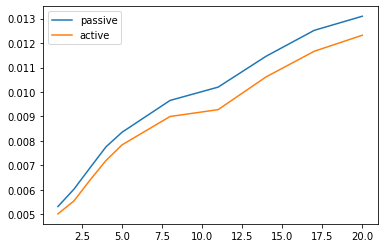

In [64]:
ns = list(range(1, 5)) + list(range(5, 21, 3))
agg = []
act = []
for n in tqdm(ns):
    tester = ClusteringTester(embeddings, labels, n_tests=1000, n_users_type1=n, n_utts_per_user_type1=7)
    agg.append(tester.test(AgglomerativeVerificator(0.72, 'cosine', 'average', 5))['guest_detection_eer'])
    act.append(tester.test(ActiveVerificator())['guest_detection_eer'])
plt.plot(ns, agg, label='passive')
plt.plot(ns, act, label='active')
plt.legend()
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [4:28:03<00:00, 2297.62s/it]


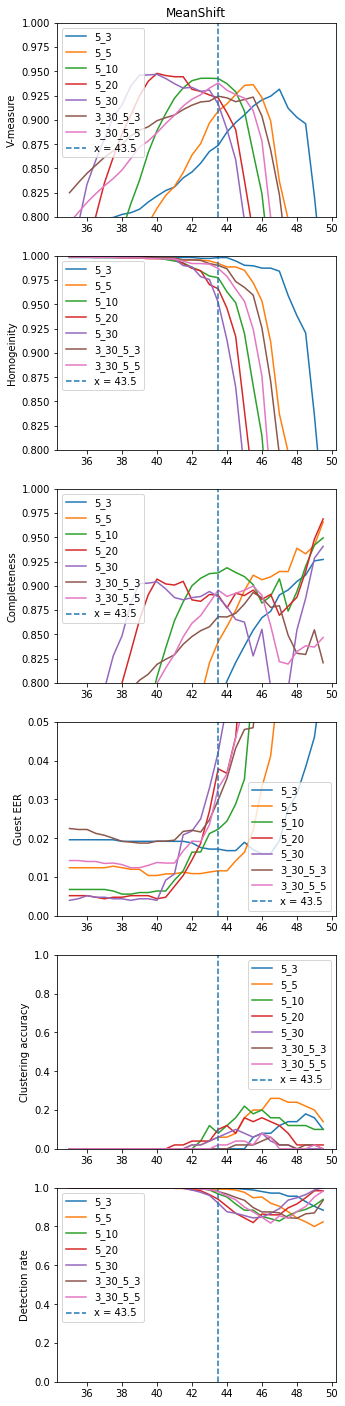

In [21]:
test_all_confs([
    (lambda th: MeanShiftVerificator(th), 1, np.arange(35, 50, 0.5), 'MeanShift'),
])

100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:47<00:00, 32.48s/it]


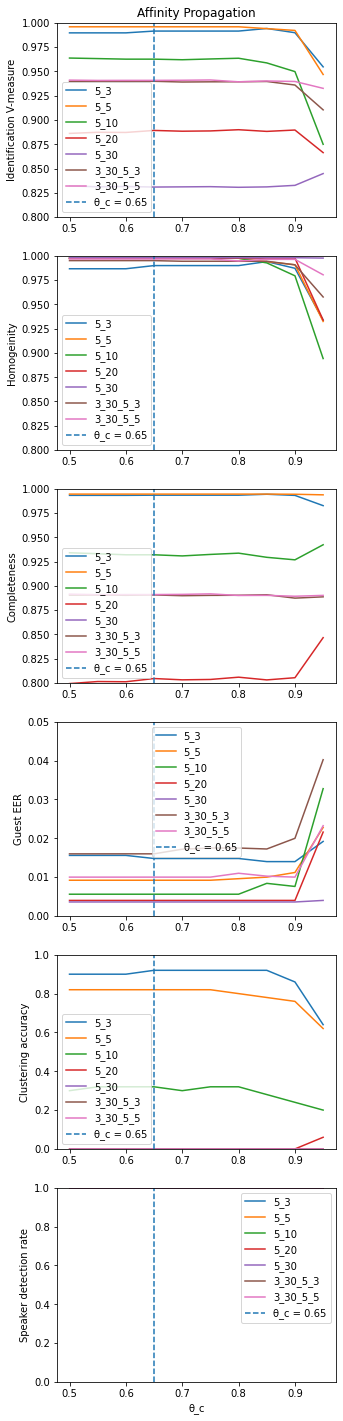

In [8]:
test_all_confs(verificators=[
    (lambda th: AffinityVerificator(damping=th), 1, np.arange(0.5, 0.99, 0.05), 50, 'Affinity Propagation'),
])

In [33]:
tester = ClusteringTester(embeddings, labels, n_tests=100, **confs[3])
tester.test(SpectralVerificator())

{'v_measure': 0.9300720955643391,
 'homogeinity': 0.9987507450725676,
 'completeness': 0.8978934244385525,
 'guest_detection_eer': 0.0051999999996264895,
 'clustering_acc': 0.71,
 'equal_rate': 0.1,
 'less_rate': 0.0,
 'more_rate': 0.19,
 'found_rate': 1.0}

In [44]:
for conf in confs:
    print(conf)
    tester = ClusteringTester(embeddings, labels, n_tests=100, **conf)
    print(tester.test(SpectralVerificator()))

{'n_users_type1': 5, 'n_utts_per_user_type1': 3}
{'v_measure': 0.9291028032885776, 'homogeinity': 0.9289773659906035, 'completeness': 0.9911959921380148, 'guest_detection_eer': 0.025394921015803498, 'clustering_acc': 0.87, 'equal_rate': 0.0, 'less_rate': 0.11, 'more_rate': 0.02, 'found_rate': 1.0}
{'n_users_type1': 5, 'n_utts_per_user_type1': 5}
{'v_measure': 0.9665947608952016, 'homogeinity': 0.9657787839128414, 'completeness': 0.9975731542894815, 'guest_detection_eer': 0.015396920615877824, 'clustering_acc': 0.92, 'equal_rate': 0.04, 'less_rate': 0.04, 'more_rate': 0.0, 'found_rate': 1.0}
{'n_users_type1': 5, 'n_utts_per_user_type1': 10}
{'v_measure': 0.9979477499187053, 'homogeinity': 0.9979179084542793, 'completeness': 0.9979776285745678, 'guest_detection_eer': 0.005998800239952067, 'clustering_acc': 0.93, 'equal_rate': 0.07, 'less_rate': 0.0, 'more_rate': 0.0, 'found_rate': 1.0}
{'n_users_type1': 5, 'n_utts_per_user_type1': 20}
{'v_measure': 0.9983581999349643, 'homogeinity': 0.99

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [18:43<00:00, 187.32s/it]


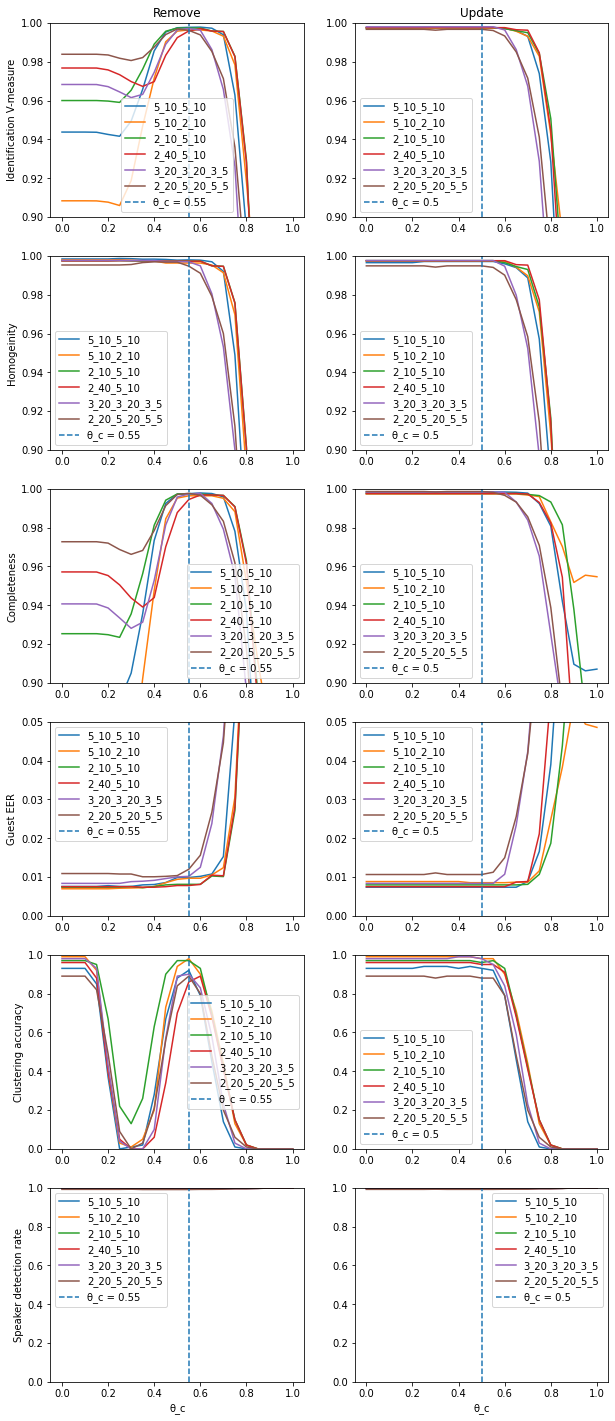

In [31]:
confs_update = [
    #dict(n_users_enrolled=5, n_utts_per_user_enrolled=10, n_users_type1=5, n_utts_per_user_type1=10),
    dict(n_users_enrolled=5, n_utts_per_user_enrolled=10, n_users_type1=2, n_utts_per_user_type1=20),
    dict(n_users_enrolled=2, n_utts_per_user_enrolled=10, n_users_type1=5, n_utts_per_user_type1=10),
    dict(n_users_enrolled=2, n_utts_per_user_enrolled=40, n_users_type1=5, n_utts_per_user_type1=10),
    #dict(n_users_enrolled=3, n_utts_per_user_enrolled=20, n_users_type1=3, n_utts_per_user_type1=20, n_users_type2=3, n_utts_per_user_type2=5),
    dict(n_users_enrolled=2, n_utts_per_user_enrolled=20, n_users_type1=5, n_utts_per_user_type1=20, n_users_type2=5, n_utts_per_user_type2=5),
]
test_all_confs([
    (lambda th: AgglomerativeVerificator(0.74, min_cluster_size=5, preenroll_threshold=th, preenroll_method='remove'), 5, np.arange(0.0, 1.01, 0.05), 100, 'Remove'),
    (lambda th: AgglomerativeUpdateVerificator(0.74, min_cluster_size=5, preenroll_threshold=th, preenroll_method='update'), 5, np.arange(0, 1.01, 0.05), 100, 'Update'),
], confs_update)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [13:48<00:00, 207.14s/it]


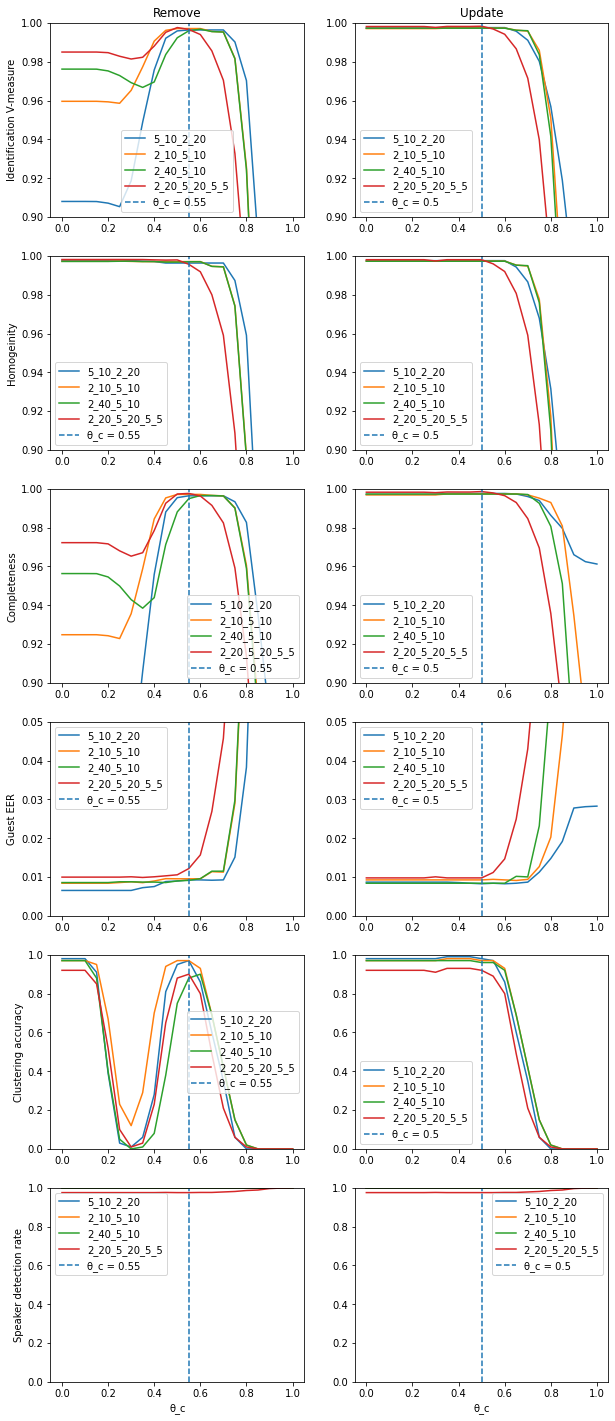

In [44]:
confs_update = [
    #dict(n_users_enrolled=3, n_utts_per_user_enrolled=5, n_users_type1=3, n_utts_per_user_type1=5),
    dict(n_users_enrolled=5, n_utts_per_user_enrolled=10, n_users_type1=2, n_utts_per_user_type1=20),
    dict(n_users_enrolled=2, n_utts_per_user_enrolled=10, n_users_type1=5, n_utts_per_user_type1=10),
    dict(n_users_enrolled=2, n_utts_per_user_enrolled=40, n_users_type1=5, n_utts_per_user_type1=10),
    #dict(n_users_enrolled=3, n_utts_per_user_enrolled=20, n_users_type1=3, n_utts_per_user_type1=20, n_users_type2=3, n_utts_per_user_type2=5),
    dict(n_users_enrolled=2, n_utts_per_user_enrolled=20, n_users_type1=5, n_utts_per_user_type1=20, n_users_type2=5, n_utts_per_user_type2=5),
]
test_all_confs([
    (lambda th: AgglomerativeVerificator(0.7, min_cluster_size=5, preenroll_threshold=th, preenroll_method='remove'), 5, np.arange(0.0, 1.01, 0.05), 100, 'Remove'),
    (lambda th: AgglomerativeUpdateVerificator(0.7, min_cluster_size=5, preenroll_threshold=th, preenroll_method='update'), 5, np.arange(0, 1.01, 0.05), 100, 'Update'),
], confs_update)

In [93]:
confs_update = [
    dict(n_users_enrolled=3, n_utts_per_user_enrolled=6, n_users_type1=3, n_utts_per_user_type1=6),
    #dict(n_users_enrolled=10, n_utts_per_user_enrolled=6, n_users_type1=3, n_utts_per_user_type1=3),
    dict(n_users_enrolled=5, n_utts_per_user_enrolled=10, n_users_type1=2, n_utts_per_user_type1=20),
    dict(n_users_enrolled=2, n_utts_per_user_enrolled=10, n_users_type1=5, n_utts_per_user_type1=10),
    dict(n_users_enrolled=2, n_utts_per_user_enrolled=40, n_users_type1=5, n_utts_per_user_type1=10),
    #dict(n_users_enrolled=3, n_utts_per_user_enrolled=20, n_users_type1=3, n_utts_per_user_type1=20, n_users_type2=3, n_utts_per_user_type2=5),
    dict(n_users_enrolled=2, n_utts_per_user_enrolled=20, n_users_type1=5, n_utts_per_user_type1=20, n_users_type2=5, n_utts_per_user_type2=5),
]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [15:26<00:00, 154.45s/it]


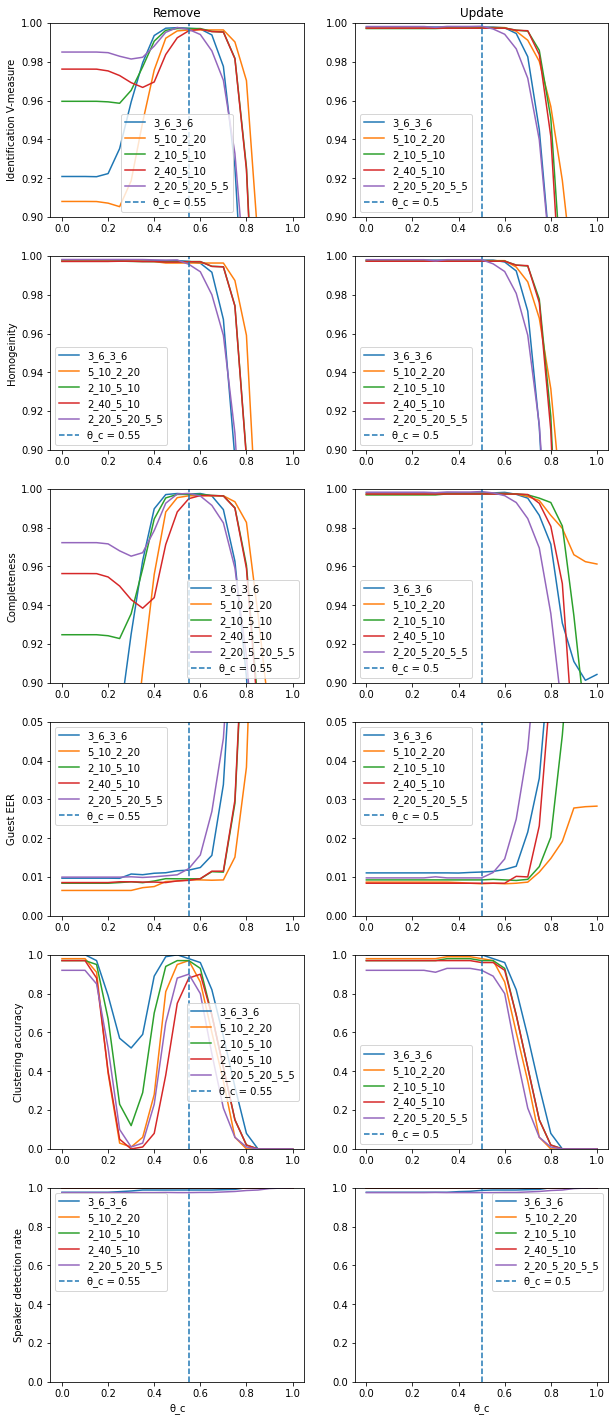

In [90]:
test_all_confs([
    (lambda th: AgglomerativeVerificator(0.7, min_cluster_size=5, preenroll_threshold=th, preenroll_method='remove'), 5, np.arange(0.0, 1.01, 0.05), 100, 'Remove'),
    (lambda th: AgglomerativeUpdateVerificator(0.7, min_cluster_size=5, preenroll_threshold=th, preenroll_method='update'), 5, np.arange(0, 1.01, 0.05), 100, 'Update'),
], confs_update)

In [94]:
def table_update(conf):
    tester = ClusteringTester(embeddings, labels, n_tests=5000, **conf)
    results = []
    results.append(dict(name='ignore', **tester.test(AgglomerativeVerificator(0.7, min_cluster_size=5))))
    results.append(dict(name='remove', **tester.test(AgglomerativeVerificator(0.7, min_cluster_size=5, preenroll_threshold=0.55, preenroll_method='remove'))))
    results.append(dict(name='modify', **tester.test(AgglomerativeUpdateVerificator(0.7, min_cluster_size=5, preenroll_threshold=0.5, preenroll_method='update'))))
    return pd.DataFrame(results)

In [95]:
table_update(confs_update[0])

name  v_measure  homogeinity  completeness  guest_detection_eer  \
0  ignore   0.998091     0.998014      0.998174             0.009388   
1  remove   0.998228     0.998180      0.998280             0.009724   
2  modify   0.998177     0.998136      0.998219             0.009272   

   clustering_acc  equal_rate  less_rate  more_rate  found_rate  
0          0.9952      0.0040     0.0008     0.0000    0.979933  
1          0.9880      0.0112     0.0006     0.0002    0.989333  
2          0.9960      0.0038     0.0002     0.0000    0.984667

In [96]:
table_update(confs_update[1])

name  v_measure  homogeinity  completeness  guest_detection_eer  \
0  ignore   0.997933     0.998202      0.997680             0.007968   
1  remove   0.997916     0.998105      0.997738             0.009576   
2  modify   0.998180     0.998276      0.998090             0.007480   

   clustering_acc  equal_rate  less_rate  more_rate  found_rate  
0          0.9746      0.0096     0.0004     0.0154    1.000000  
1          0.9646      0.0242     0.0000     0.0112    1.000000  
2          0.9826      0.0106     0.0000     0.0068    0.999971

In [97]:
table_update(confs_update[2])

name  v_measure  homogeinity  completeness  guest_detection_eer  \
0  ignore   0.997898     0.998130      0.997680             0.008546   
1  remove   0.997906     0.998082      0.997739             0.009240   
2  modify   0.998006     0.998140      0.997880             0.008384   

   clustering_acc  equal_rate  less_rate  more_rate  found_rate  
0          0.9792      0.0082     0.0002     0.0124         1.0  
1          0.9718      0.0186     0.0000     0.0096         1.0  
2          0.9836      0.0082     0.0002     0.0080         1.0

In [98]:
table_update(confs_update[3])

name  v_measure  homogeinity  completeness  guest_detection_eer  \
0  ignore   0.997945     0.998209      0.997693             0.007896   
1  remove   0.996705     0.998074      0.995395             0.008964   
2  modify   0.997993     0.998209      0.997787             0.007892   

   clustering_acc  equal_rate  less_rate  more_rate  found_rate  
0          0.9664      0.0110        0.0     0.0226         1.0  
1          0.8988      0.0238        0.0     0.0774         1.0  
2          0.9710      0.0116        0.0     0.0174         1.0

In [99]:
table_update(confs_update[4])

name  v_measure  homogeinity  completeness  guest_detection_eer  \
0  ignore   0.997657     0.997585      0.997743             0.009970   
1  remove   0.997159     0.997082      0.997260             0.011163   
2  modify   0.997670     0.997543      0.997810             0.009992   

   clustering_acc  equal_rate  less_rate  more_rate  found_rate  
0          0.9608      0.0106     0.0096     0.0190    0.971233  
1          0.9200      0.0322     0.0160     0.0318    0.971250  
2          0.9608      0.0140     0.0102     0.0150    0.971283

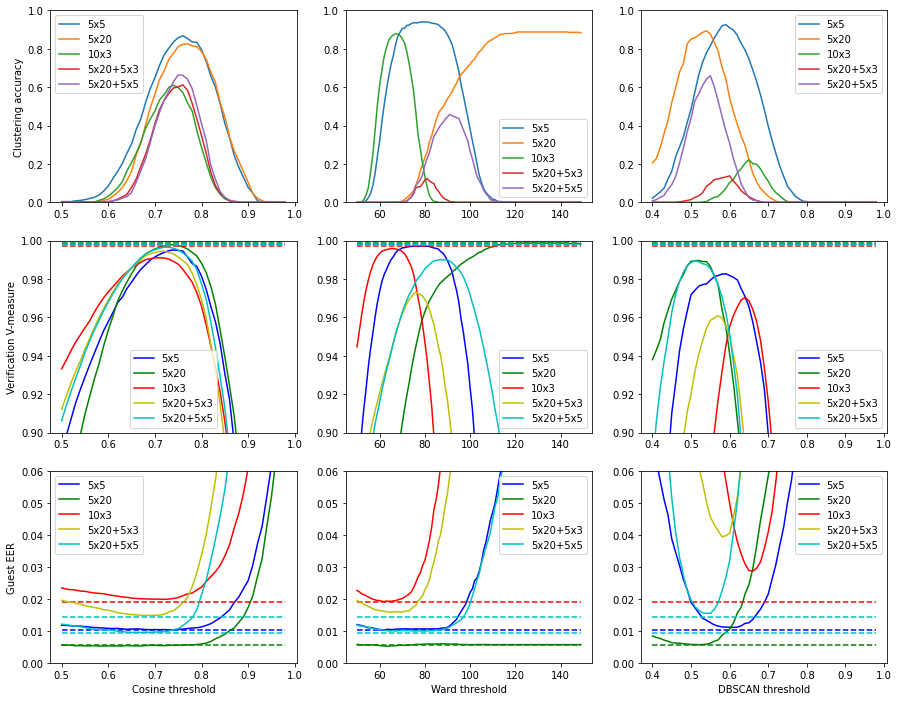

In [97]:
plt.figure(figsize=(15, 12))

plt.subplot(3, 3, 1)
plt.plot(x_cos, acc_5_5_cos, label='5x5')
plt.plot(x_cos, acc_5_20_cos, label='5x20')
plt.plot(x_cos, acc_10_3_cos, label='10x3')
plt.plot(x_cos, acc_mix_cos, label='5x20+5x3')
plt.plot(x_cos, acc_mix2_cos, label='5x20+5x5')
plt.legend()
plt.ylim(0.0, 1.0)
plt.ylabel('Clustering accuracy')

plt.subplot(3, 3, 2)
plt.plot(x_ward, acc_5_5_ward, label='5x5')
plt.plot(x_ward, acc_5_20_ward, label='5x20')
plt.plot(x_ward, acc_10_3_ward, label='10x3')
plt.plot(x_ward, acc_mix_ward, label='5x20+5x3')
plt.plot(x_ward, acc_mix2_ward, label='5x20+5x5')
plt.legend()
plt.ylim(0.0, 1.0)

plt.subplot(3, 3, 3)
plt.plot(x_dbscan, acc_5_5_dbscan, label='5x5')
plt.plot(x_dbscan, acc_5_20_dbscan, label='5x20')
plt.plot(x_dbscan, acc_10_3_dbscan, label='10x3')
plt.plot(x_dbscan, acc_mix_dbscan, label='5x20+5x3')
plt.plot(x_dbscan, acc_mix2_dbscan, label='5x20+5x5')
plt.legend()
plt.ylim(0.0, 1.0)

plt.subplot(3, 3, 4)
plt.plot(x_cos, vm_5_5_cos, 'b', label='5x5')
plt.plot(x_cos, [results_5_5['active']['v_measure_total']] * len(x_cos), 'b--')
plt.plot(x_cos, vm_5_20_cos, 'g', label='5x20')
plt.plot(x_cos, [results_5_20['active']['v_measure_total']] * len(x_cos), 'g--')
plt.plot(x_cos, vm_10_3_cos, 'r', label='10x3')
plt.plot(x_cos, [results_10_3['active']['v_measure_total']] * len(x_cos), 'r--')
plt.plot(x_cos, vm_mix_cos, 'y', label='5x20+5x3')
plt.plot(x_cos, [results_5_20_5_3['active']['v_measure_total']] * len(x_cos), 'c--')
plt.plot(x_cos, vm_mix2_cos, 'c', label='5x20+5x5')
plt.plot(x_cos, [results_5_20_5_5['active']['v_measure_total']] * len(x_cos), 'c--')
plt.legend()
plt.ylim(0.9, 1.0)
plt.ylabel('Verification V-measure')

plt.subplot(3, 3, 5)
plt.plot(x_ward, vm_5_5_ward, 'b', label='5x5')
plt.plot(x_ward, [results_5_5['active']['v_measure_total']] * len(x_ward), 'b--')
plt.plot(x_ward, vm_5_20_ward, 'g', label='5x20')
plt.plot(x_ward, [results_5_20['active']['v_measure_total']] * len(x_ward), 'g--')
plt.plot(x_ward, vm_10_3_ward, 'r', label='10x3')
plt.plot(x_ward, [results_10_3['active']['v_measure_total']] * len(x_ward), 'r--')
plt.plot(x_ward, vm_mix_ward, 'y', label='5x20+5x3')
plt.plot(x_ward, [results_5_20_5_3['active']['v_measure_total']] * len(x_ward), 'c--')
plt.plot(x_ward, vm_mix2_ward, 'c', label='5x20+5x5')
plt.plot(x_ward, [results_5_20_5_5['active']['v_measure_total']] * len(x_ward), 'c--')
plt.legend()
plt.ylim(0.9, 1.0)

plt.subplot(3, 3, 6)
plt.plot(x_dbscan, vm_5_5_dbscan, 'b', label='5x5')
plt.plot(x_dbscan, [results_5_5['active']['v_measure_total']] * len(x_dbscan), 'b--')
plt.plot(x_dbscan, vm_5_20_dbscan, 'g', label='5x20')
plt.plot(x_dbscan, [results_5_20['active']['v_measure_total']] * len(x_dbscan), 'g--')
plt.plot(x_dbscan, vm_10_3_dbscan, 'r', label='10x3')
plt.plot(x_dbscan, [results_10_3['active']['v_measure_total']] * len(x_dbscan), 'r--')
plt.plot(x_dbscan, vm_mix_dbscan, 'y', label='5x20+5x3')
plt.plot(x_dbscan, [results_5_20_5_3['active']['v_measure_total']] * len(x_dbscan), 'c--')
plt.plot(x_dbscan, vm_mix2_dbscan, 'c', label='5x20+5x5')
plt.plot(x_dbscan, [results_5_20_5_5['active']['v_measure_total']] * len(x_dbscan), 'c--')
plt.legend()
plt.ylim(0.9, 1.0)

plt.subplot(3, 3, 7)
plt.plot(x_cos, eer_5_5_cos, 'b', label='5x5')
plt.plot(x_cos, [results_5_5['active']['guest_detection_eer']] * len(x_cos), 'b--')
plt.plot(x_cos, eer_5_20_cos, 'g', label='5x20')
plt.plot(x_cos, [results_5_20['active']['guest_detection_eer']] * len(x_cos), 'g--')
plt.plot(x_cos, eer_10_3_cos, 'r', label='10x3')
plt.plot(x_cos, [results_10_3['active']['guest_detection_eer']] * len(x_cos), 'r--')
plt.plot(x_cos, eer_mix_cos, 'y', label='5x20+5x3')
plt.plot(x_cos, [results_5_20_5_3['active']['guest_detection_eer']] * len(x_cos), 'c--')
plt.plot(x_cos, eer_mix2_cos, 'c', label='5x20+5x5')
plt.plot(x_cos, [results_5_20_5_5['active']['guest_detection_eer']] * len(x_cos), 'c--')
plt.legend()
plt.ylim(0.0, 0.06)
plt.xlabel('Cosine threshold')
plt.ylabel('Guest EER')

plt.subplot(3, 3, 8)
plt.plot(x_ward, eer_5_5_ward, 'b', label='5x5')
plt.plot(x_ward, [results_5_5['active']['guest_detection_eer']] * len(x_ward), 'b--')
plt.plot(x_ward, eer_5_20_ward, 'g', label='5x20')
plt.plot(x_ward, [results_5_20['active']['guest_detection_eer']] * len(x_ward), 'g--')
plt.plot(x_ward, eer_10_3_ward, 'r', label='10x3')
plt.plot(x_ward, [results_10_3['active']['guest_detection_eer']] * len(x_ward), 'r--')
plt.plot(x_ward, eer_mix_ward, 'y', label='5x20+5x3')
plt.plot(x_ward, [results_5_20_5_3['active']['guest_detection_eer']] * len(x_ward), 'c--')
plt.plot(x_ward, eer_mix2_ward, 'c', label='5x20+5x5')
plt.plot(x_ward, [results_5_20_5_5['active']['guest_detection_eer']] * len(x_ward), 'c--')
plt.legend()
plt.ylim(0.0, 0.06)
plt.xlabel('Ward threshold')

plt.subplot(3, 3, 9)
plt.plot(x_dbscan, eer_5_5_dbscan, 'b', label='5x5')
plt.plot(x_dbscan, [results_5_5['active']['guest_detection_eer']] * len(x_dbscan), 'b--')
plt.plot(x_dbscan, eer_5_20_dbscan, 'g', label='5x20')
plt.plot(x_dbscan, [results_5_20['active']['guest_detection_eer']] * len(x_dbscan), 'g--')
plt.plot(x_dbscan, eer_10_3_dbscan, 'r', label='10x3')
plt.plot(x_dbscan, [results_10_3['active']['guest_detection_eer']] * len(x_dbscan), 'r--')
plt.plot(x_dbscan, eer_mix_dbscan, 'y', label='5x20+5x3')
plt.plot(x_dbscan, [results_5_20_5_3['active']['guest_detection_eer']] * len(x_dbscan), 'c--')
plt.plot(x_dbscan, eer_mix2_dbscan, 'c', label='5x20+5x5')
plt.plot(x_dbscan, [results_5_20_5_5['active']['guest_detection_eer']] * len(x_dbscan), 'c--')
plt.legend()
plt.ylim(0.0, 0.06)
plt.xlabel('DBSCAN threshold')

plt.show()

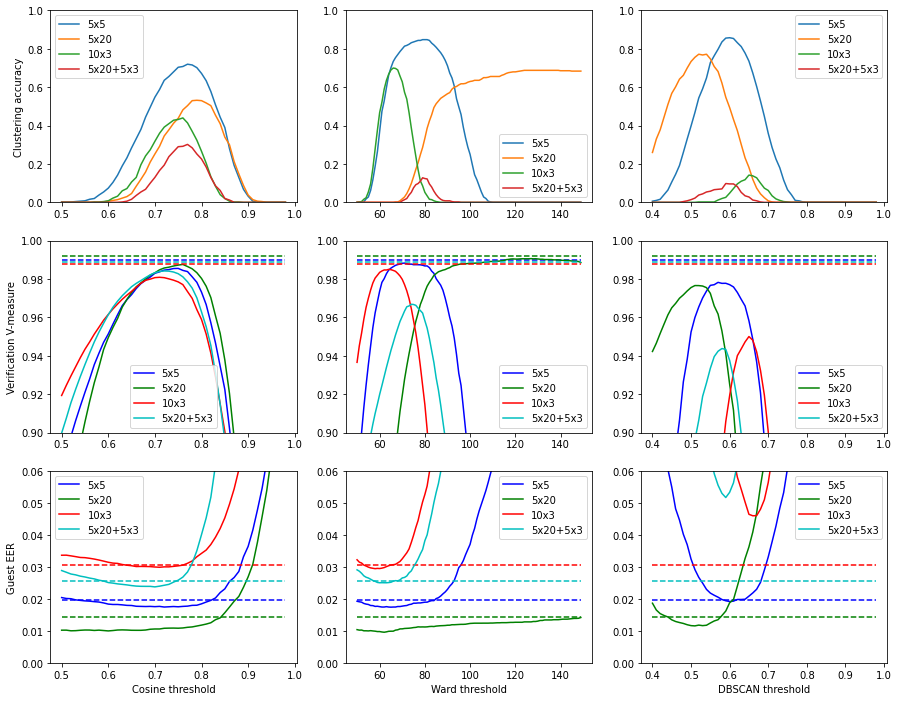

In [17]:
plt.figure(figsize=(15, 12))

plt.subplot(3, 3, 1)
plt.plot(x_cos, acc_5_5_cos, label='5x5')
plt.plot(x_cos, acc_5_20_cos, label='5x20')
plt.plot(x_cos, acc_10_3_cos, label='10x3')
plt.plot(x_cos, acc_mix_cos, label='5x20+5x3')
plt.legend()
plt.ylim(0.0, 1.0)
plt.ylabel('Clustering accuracy')

plt.subplot(3, 3, 2)
plt.plot(x_ward, acc_5_5_ward, label='5x5')
plt.plot(x_ward, acc_5_20_ward, label='5x20')
plt.plot(x_ward, acc_10_3_ward, label='10x3')
plt.plot(x_ward, acc_mix_ward, label='5x20+5x3')
plt.legend()
plt.ylim(0.0, 1.0)

plt.subplot(3, 3, 3)
plt.plot(x_dbscan, acc_5_5_dbscan, label='5x5')
plt.plot(x_dbscan, acc_5_20_dbscan, label='5x20')
plt.plot(x_dbscan, acc_10_3_dbscan, label='10x3')
plt.plot(x_dbscan, acc_mix_dbscan, label='5x20+5x3')
plt.legend()
plt.ylim(0.0, 1.0)

plt.subplot(3, 3, 4)
plt.plot(x_cos, vm_5_5_cos, 'b', label='5x5')
plt.plot(x_cos, [results_5_5['active']['v_measure_total']] * len(x_cos), 'b--')
plt.plot(x_cos, vm_5_20_cos, 'g', label='5x20')
plt.plot(x_cos, [results_5_20['active']['v_measure_total']] * len(x_cos), 'g--')
plt.plot(x_cos, vm_10_3_cos, 'r', label='10x3')
plt.plot(x_cos, [results_10_3['active']['v_measure_total']] * len(x_cos), 'r--')
plt.plot(x_cos, vm_mix_cos, 'c', label='5x20+5x3')
plt.plot(x_cos, [results_5_20_5_3['active']['v_measure_total']] * len(x_cos), 'c--')
plt.legend()
plt.ylim(0.9, 1.0)
plt.ylabel('Verification V-measure')

plt.subplot(3, 3, 5)
plt.plot(x_ward, vm_5_5_ward, 'b', label='5x5')
plt.plot(x_ward, [results_5_5['active']['v_measure_total']] * len(x_ward), 'b--')
plt.plot(x_ward, vm_5_20_ward, 'g', label='5x20')
plt.plot(x_ward, [results_5_20['active']['v_measure_total']] * len(x_ward), 'g--')
plt.plot(x_ward, vm_10_3_ward, 'r', label='10x3')
plt.plot(x_ward, [results_10_3['active']['v_measure_total']] * len(x_ward), 'r--')
plt.plot(x_ward, vm_mix_ward, 'c', label='5x20+5x3')
plt.plot(x_ward, [results_5_20_5_3['active']['v_measure_total']] * len(x_ward), 'c--')
plt.legend()
plt.ylim(0.9, 1.0)

plt.subplot(3, 3, 6)
plt.plot(x_dbscan, vm_5_5_dbscan, 'b', label='5x5')
plt.plot(x_dbscan, [results_5_5['active']['v_measure_total']] * len(x_dbscan), 'b--')
plt.plot(x_dbscan, vm_5_20_dbscan, 'g', label='5x20')
plt.plot(x_dbscan, [results_5_20['active']['v_measure_total']] * len(x_dbscan), 'g--')
plt.plot(x_dbscan, vm_10_3_dbscan, 'r', label='10x3')
plt.plot(x_dbscan, [results_10_3['active']['v_measure_total']] * len(x_dbscan), 'r--')
plt.plot(x_dbscan, vm_mix_dbscan, 'c', label='5x20+5x3')
plt.plot(x_dbscan, [results_5_20_5_3['active']['v_measure_total']] * len(x_dbscan), 'c--')
plt.legend()
plt.ylim(0.9, 1.0)

plt.subplot(3, 3, 7)
plt.plot(x_cos, eer_5_5_cos, 'b', label='5x5')
plt.plot(x_cos, [results_5_5['active']['guest_detection_eer']] * len(x_cos), 'b--')
plt.plot(x_cos, eer_5_20_cos, 'g', label='5x20')
plt.plot(x_cos, [results_5_20['active']['guest_detection_eer']] * len(x_cos), 'g--')
plt.plot(x_cos, eer_10_3_cos, 'r', label='10x3')
plt.plot(x_cos, [results_10_3['active']['guest_detection_eer']] * len(x_cos), 'r--')
plt.plot(x_cos, eer_mix_cos, 'c', label='5x20+5x3')
plt.plot(x_cos, [results_5_20_5_3['active']['guest_detection_eer']] * len(x_cos), 'c--')
plt.legend()
plt.ylim(0.0, 0.06)
plt.xlabel('Cosine threshold')
plt.ylabel('Guest EER')

plt.subplot(3, 3, 8)
plt.plot(x_ward, eer_5_5_ward, 'b', label='5x5')
plt.plot(x_ward, [results_5_5['active']['guest_detection_eer']] * len(x_ward), 'b--')
plt.plot(x_ward, eer_5_20_ward, 'g', label='5x20')
plt.plot(x_ward, [results_5_20['active']['guest_detection_eer']] * len(x_ward), 'g--')
plt.plot(x_ward, eer_10_3_ward, 'r', label='10x3')
plt.plot(x_ward, [results_10_3['active']['guest_detection_eer']] * len(x_ward), 'r--')
plt.plot(x_ward, eer_mix_ward, 'c', label='5x20+5x3')
plt.plot(x_ward, [results_5_20_5_3['active']['guest_detection_eer']] * len(x_ward), 'c--')
plt.legend()
plt.ylim(0.0, 0.06)
plt.xlabel('Ward threshold')

plt.subplot(3, 3, 9)
plt.plot(x_dbscan, eer_5_5_dbscan, 'b', label='5x5')
plt.plot(x_dbscan, [results_5_5['active']['guest_detection_eer']] * len(x_dbscan), 'b--')
plt.plot(x_dbscan, eer_5_20_dbscan, 'g', label='5x20')
plt.plot(x_dbscan, [results_5_20['active']['guest_detection_eer']] * len(x_dbscan), 'g--')
plt.plot(x_dbscan, eer_10_3_dbscan, 'r', label='10x3')
plt.plot(x_dbscan, [results_10_3['active']['guest_detection_eer']] * len(x_dbscan), 'r--')
plt.plot(x_dbscan, eer_mix_dbscan, 'c', label='5x20+5x3')
plt.plot(x_dbscan, [results_5_20_5_3['active']['guest_detection_eer']] * len(x_dbscan), 'c--')
plt.legend()
plt.ylim(0.0, 0.06)
plt.xlabel('DBSCAN threshold')

plt.show()

In [101]:
eer = np.array(json.load(open('data/eer_results.json')))

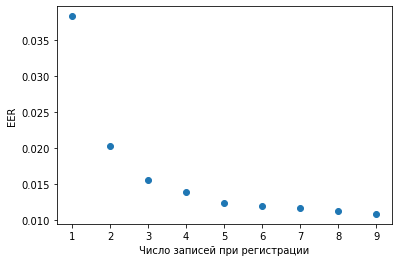

In [102]:
plt.scatter(eer[:, 0], eer[:, 1])
plt.ylabel('EER')
plt.xlabel('Число записей при регистрации')
plt.show()

In [103]:
table_active(dict(n_users_type1=10, n_utts_per_user_type1=5))

name  v_measure  homogeinity  completeness  guest_detection_eer  \
0  active   0.998055     0.998023      0.998087              0.01221   

   clustering_acc  equal_rate  less_rate  more_rate  found_rate  
0             1.0         0.0        0.0        0.0         1.0

In [108]:
def test_conf(conf):
    tester = ClusteringTester(embeddings, labels, n_tests=5000, **conf)
    return tester.test(AgglomerativeVerificator(0.7, 'cosine', 'average', 5))

In [110]:
results = []
for i in range(5, 25, 3):
    print(i)
    res = test_conf(dict(n_users_type1=10, n_utts_per_user_type1=i))
    results.append(res)
    print()

5

8

11

14

17

20

23



In [112]:
results_6_7 = []
for i in range(6, 8):
    print(i)
    res = test_conf(dict(n_users_type1=10, n_utts_per_user_type1=i))
    results_6_7.append(res)
    print()

6

7



In [113]:
results_6_7

[{'v_measure': 0.9980478353885315,
  'homogeinity': 0.9979295323058419,
  'completeness': 0.998171834333731,
  'guest_detection_eer': 0.011580000000669863,
  'clustering_acc': 0.9822,
  'equal_rate': 0.0148,
  'less_rate': 0.003,
  'more_rate': 0.0,
  'found_rate': 0.9804400000000002},
 {'v_measure': 0.9981888554710553,
  'homogeinity': 0.9981190783453326,
  'completeness': 0.998261207369877,
  'guest_detection_eer': 0.01096744656949652,
  'clustering_acc': 0.983,
  'equal_rate': 0.0156,
  'less_rate': 0.0014,
  'more_rate': 0.0,
  'found_rate': 0.9916599999999999}]

In [115]:
x = [5, 6, 7, 8, 11, 14, 17, 20, 23]
ivm = [0.9970674809135013, 0.9980478353885315, 0.9981888554710553, 0.9982357926640282, 0.9981683134969138, 0.9981205808722374, 0.9981928909853357, 0.9982998396407116, 0.9983740397678379]
geer = [0.012777786112526958, 0.011580000000669863, 0.01096744656949652, 0.010616128572458168, 0.00878798242420938, 0.007837984324147259, 0.0072099855800291, 0.006927999999823851, 0.006773986451790191]

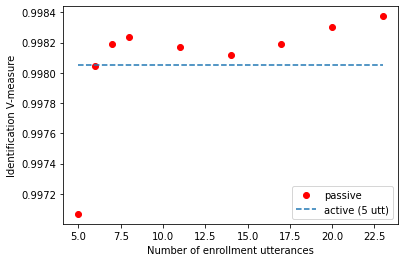

In [120]:
plt.scatter(x, ivm, color='red', label='passive')
plt.plot(x, [0.998055] * len(x), '--', label='active (5 utt)')
plt.xlabel('Number of enrollment utterances')
plt.ylabel('Identification V-measure')
plt.legend()
plt.show()

In [ ]:
plt.scatter(x, geer, color='red', label='passive')
plt.plot(x, [0.01221] * len(x), '--', label='active (5 utt)')
plt.xlabel('Number of enrollment utterances')
plt.ylabel('Guest EER')
plt.legend()
plt.show()